# Port Mapping Using Behavioral Vessel Data

## Task: (Basic)
Mapping of ports and waiting areas. Create sets of area candidates according to vessels’ behavior, and based on tagged data, create a model that classifies areas as ports, port waiting areas or other.

## Data description:
1. Vessels - information about the vessels of interest. Relevant fields are:
    - classcalc - vessel type
    - flag - under which regulations the vessel operates
    - grosstonnage & deadweight - both relate to the vessel weight :
        - Gross tonnage - in simple words - the approximate weight of the vessel
        - Deadweight - basically, is how much a vessel can carry (sum of fuel, cargo, crew, etc)
    - size - usually referred to the vessel's length
    - max_draught - maximal depth possible for the vessel


2. Activities - 
    - Drifting - when a vessel shuts its engine and lets the the water carry it
    - Anchoring - when a vessel anchors
    - Mooring - when a vessel is tied to a static object
    - Port call - when a vessel enters a port polygon and stays there more than 30 minutes


3. Ports - port information


4. Polygons - the layers of interest namely: ports, port waiting areas and docks

Few notes:
1. All of the time based data set contain info between 20200801 and 20210205
2. Data sets that may not have constant # of fields are saved as jsons, while others are saved as csvs
3. jsons may contain '<not serializable>' tags. the field '_id' is always equal to the id of the record. If you feel that some of this info is important LMK and we'll figure out how to recreate it.
4. There is an additional type of data that I wanted to extract for you which is in polygon activities, however it is too big to extract the same way and may require usage of spark so we may add it later. In any case you can cross the activities info with polygons info to get the most of the relevant content 

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

## SUMMARY

In [161]:
df_names = {'Anchoring': anchoring_df,
            'Morring': mooring_df, 
            'Drifting': drifting_df, 
            'Port calls': port_calls_df}
for k, v in df_names.items():
    print(f'{k}:')
    print(f'{v.shape[0]} records of {v.vesselId.nunique()} ships.')
    print(f'Missing values by field:\n {v.isnull().sum()}')
    print('')

Anchoring:
836049 records of 42137 ships.
Missing values by field:
 Unnamed: 0           0
_id                  0
vesselId             0
startDate            0
endDate           6583
createdDate          0
type                 0
confidence           0
isInProgress         0
firstBlip            0
previousPort     22419
enrichers        15028
lastBlip          6583
duration          6583
nextPort         67195
isOutlier       811325
dtype: int64

Morring:
3509070 records of 80551 ships.
Missing values by field:
 Unnamed: 0           0
_id                  0
vesselId             0
startDate            0
endDate          21907
createdDate          0
type                 0
confidence           0
isInProgress         0
firstBlip            0
lastBlip         21907
duration         21907
previousPort    111111
enrichers       114164
nextPort        292879
dtype: int64

Drifting:
226751 records of 30905 ships.
Missing values by field:
 Unnamed: 0           0
_id                  0
vesselId   

## Vessels Behaviour

#### Anchoring

In [5]:
anchoring_df = pd.read_csv('Data/anchoring.csv')

In [6]:
print(anchoring_df.shape)
print(anchoring_df.info())
anchoring_df.tail()

(836049, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836049 entries, 0 to 836048
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    836049 non-null  object 
 1   _id           836049 non-null  object 
 2   vesselId      836049 non-null  object 
 3   startDate     836049 non-null  object 
 4   endDate       829466 non-null  object 
 5   createdDate   836049 non-null  object 
 6   type          836049 non-null  object 
 7   confidence    836049 non-null  float64
 8   isInProgress  836049 non-null  bool   
 9   firstBlip     836049 non-null  object 
 10  previousPort  813630 non-null  object 
 11  enrichers     821021 non-null  object 
 12  lastBlip      829466 non-null  object 
 13  duration      829466 non-null  float64
 14  nextPort      768854 non-null  object 
 15  isOutlier     24724 non-null   object 
dtypes: bool(1), float64(2), object(13)
memory usage: 96.5+ MB
None


,Unnamed: 0,_id,vesselId,startDate,endDate,createdDate,type,confidence,isInProgress,firstBlip,previousPort,enrichers,lastBlip,duration,nextPort,isOutlier
836044,5f24b8003addf64fbc73cd55,5f24b8003addf64fbc73cd55,590b4cbd9b07d843b9a5466a,2020-08-01 00:32:00.000,2020-08-01 15:52:35.000,2021-02-01 20:26:47.818,LOW_SPEED_ANCHORED,0.90,False,"{'sog': 3.0, 'th': 106.0, 'geometry': {'type':...",5358fc78b68ca120a07dbb7d,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 0.1, 'th': 113.3, 'geometry': {'type':...",15.343056,5358fc78b68ca120a07dbcda,NaN
836045,5f24b7ad7039a1acaf62c1a0,5f24b7ad7039a1acaf62c1a0,5905f91b1fa39e732ab5c363,2020-08-01 00:30:37.000,2020-08-01 18:44:45.000,2021-02-01 20:26:47.818,LOW_SPEED_ANCHORED,0.90,False,"{'sog': 1.7, 'th': 246.0, 'geometry': {'type':...",5358fc77b68ca120a07db059,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 0.1, 'th': 356.9, 'geometry': {'type':...",18.235556,53ec6bb7afccdb7b1a2be97c,NaN
836046,5f24b58569e4b8a520d4a25b,5f24b58569e4b8a520d4a25b,5905e5721531285ce3228470,2020-08-01 00:21:25.000,2020-08-01 02:35:59.000,2021-02-01 20:26:47.818,LOW_SPEED_ANCHORED,0.75,False,"{'sog': 0.3, 'th': 323.7, 'geometry': {'type':...",5358fc77b68ca120a07db183,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 1.7, 'th': 149.4, 'geometry': {'type':...",2.242778,5358fc77b68ca120a07db183,NaN
836047,5f24b1fd6354962b1228362e,5f24b1fd6354962b1228362e,5906ffc66312aa06ea3058ab,2020-08-01 00:06:21.000,2020-08-01 03:12:00.000,2021-02-01 20:26:47.818,LOW_SPEED_ANCHORED,0.75,False,"{'sog': 1.5, 'th': 49.2, 'geometry': {'type': ...",54eb0036c423c5aa171de55a,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 0.2, 'th': 360.0, 'geometry': {'type':...",3.094167,54e47cac07b65aab17ea3b5e,NaN
836048,5f24b1fc4acdce1290fd5157,5f24b1fc4acdce1290fd5157,590684750b58c06eb4f887d4,2020-08-01 00:06:20.000,2020-08-01 08:18:58.000,2021-02-01 20:26:47.818,LOW_SPEED_ANCHORED,0.90,False,"{'sog': 0.6, 'th': 256.6, 'geometry': {'type':...",5358fc78b68ca120a07db9f4,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 0.5, 'th': 102.9, 'geometry': {'type':...",8.210556,5358fc78b68ca120a07dbad1,NaN


In [7]:
# redundent column
anchoring_df['Unnamed: 0'].equals(anchoring_df['_id'])

True

In [8]:
# how many vessels have records of anchoring
anchoring_df['vesselId'].nunique()

42137

In [9]:
anchoring_df['type'].value_counts()

LOW_SPEED_ANCHORED    836049
Name: type, dtype: int64

In [10]:
anchoring_df['confidence'].value_counts()

0.90    748122
0.75     87927
Name: confidence, dtype: int64

In [11]:
anchoring_df.loc[836048,'enrichers']

"{'previousNextPort': {'previousPort': ObjectId('5358fc78b68ca120a07db9f4'), 'previousPortStart': datetime.datetime(2020, 7, 28, 12, 2, 15), 'previousPortEnd': datetime.datetime(2020, 7, 29, 2, 28, 33), 'nextPort': ObjectId('5358fc78b68ca120a07dbad1'), 'nextPortStart': datetime.datetime(2020, 8, 1, 12, 20, 21), 'nextPortEnd': datetime.datetime(2020, 8, 2, 6, 15, 19)}}"

#### Mooring

In [12]:
mooring_df = pd.read_csv('Data/mooring.csv')

In [13]:
print(mooring_df.shape)
print(mooring_df.info())
mooring_df.tail()

(3509070, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509070 entries, 0 to 3509069
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   _id           object 
 2   vesselId      object 
 3   startDate     object 
 4   endDate       object 
 5   createdDate   object 
 6   type          object 
 7   confidence    float64
 8   isInProgress  bool   
 9   firstBlip     object 
 10  lastBlip      object 
 11  duration      float64
 12  previousPort  object 
 13  enrichers     object 
 14  nextPort      object 
dtypes: bool(1), float64(2), object(12)
memory usage: 378.2+ MB
None


,Unnamed: 0,_id,vesselId,startDate,endDate,createdDate,type,confidence,isInProgress,firstBlip,lastBlip,duration,previousPort,enrichers,nextPort
3509065,5f24b1fce46be9df59d36e85,5f24b1fce46be9df59d36e85,5905c3473d57334c83c36abf,2020-08-01 00:06:20.000,2020-08-03 13:28:35.000,2020-09-29 22:50:15.822,LOW_SPEED_MOORED,0.9,False,"{'sog': 2.5, 'th': 314.0, 'geometry': {'type':...","{'sog': 1.9, 'th': 182.0, 'geometry': {'type':...",61.370833,5358fc77b68ca120a07db6b0,{'previousNextPort': {'previousPort': ObjectId...,5358fc77b68ca120a07db6b0
3509066,5f24b1af82d1c4b425bcc206,5f24b1af82d1c4b425bcc206,5905c3511c9e904c64330a9e,2020-08-01 00:05:03.000,2020-08-02 04:07:21.000,2020-09-29 22:50:15.822,LOW_SPEED_MOORED,0.9,False,"{'sog': 2.1, 'th': 69.6, 'geometry': {'type': ...","{'sog': 3.0, 'th': 280.7, 'geometry': {'type':...",28.038333,5358fc78b68ca120a07dbcda,{'previousNextPort': {'previousPort': ObjectId...,5358fc77b68ca120a07db350
3509067,5f24b191141dda91fab6e8f4,5f24b191141dda91fab6e8f4,5905c34d3d57334c83c36c85,2020-08-01 00:04:33.000,2020-08-02 19:52:22.000,2020-09-29 22:50:15.822,LOW_SPEED_MOORED,0.9,False,"{'sog': 2.7, 'th': 352.7, 'geometry': {'type':...","{'sog': 2.7, 'th': 84.5, 'geometry': {'type': ...",43.796944,5358fc78b68ca120a07dba70,{'previousNextPort': {'previousPort': ObjectId...,5358fc78b68ca120a07dbc02
3509068,5f24b1736e40b17e8a17c989,5f24b1736e40b17e8a17c989,5905c34be7492158394ae242,2020-08-01 00:04:03.000,2020-08-01 06:09:33.000,2020-09-29 22:50:15.822,LOW_SPEED_MOORED,0.9,False,"{'sog': 0.9, 'th': 94.1, 'geometry': {'type': ...","{'sog': 0.9, 'th': 171.4, 'geometry': {'type':...",6.091667,5358fc78b68ca120a07db8ea,{'previousNextPort': {'previousPort': ObjectId...,5358fc78b68ca120a07db8ea
3509069,5f24b115c3490ee7f9c9d94c,5f24b115c3490ee7f9c9d94c,5a478010c565ab0c40c1cccc,2020-08-01 00:02:29.000,2020-08-04 09:02:18.000,2020-09-29 22:50:15.822,LOW_SPEED_MOORED,0.9,False,"{'sog': 0.8, 'th': 51.6, 'geometry': {'type': ...","{'sog': 0.0, 'th': 84.2, 'geometry': {'type': ...",80.996944,5358fc78b68ca120a07db9f4,{'previousNextPort': {'previousPort': ObjectId...,57c3f14e34b0b6f275bf131e


In [14]:
mooring_df['type'].value_counts()

LOW_SPEED_MOORED    3509070
Name: type, dtype: int64

In [15]:
mooring_df['vesselId'].nunique()

80551

#### Drifting

In [16]:
drifting_df = pd.read_csv('Data/drifting.csv')

In [17]:
print(drifting_df.shape)
print(drifting_df.info())
drifting_df.tail()

(226751, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226751 entries, 0 to 226750
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    226751 non-null  object 
 1   _id           226751 non-null  object 
 2   vesselId      226751 non-null  object 
 3   startDate     226751 non-null  object 
 4   endDate       226125 non-null  object 
 5   createdDate   226751 non-null  object 
 6   type          226751 non-null  object 
 7   confidence    226751 non-null  float64
 8   isInProgress  226751 non-null  bool   
 9   firstBlip     226751 non-null  object 
 10  previousPort  218728 non-null  object 
 11  enrichers     221734 non-null  object 
 12  lastBlip      226125 non-null  object 
 13  duration      226125 non-null  float64
 14  isOutlier     65229 non-null   object 
 15  nextPort      199048 non-null  object 
dtypes: bool(1), float64(2), object(13)
memory usage: 26.2+ MB
None


,Unnamed: 0,_id,vesselId,startDate,endDate,createdDate,type,confidence,isInProgress,firstBlip,previousPort,enrichers,lastBlip,duration,isOutlier,nextPort
226746,5f24bd51e9258b55e27683e7,5f24bd51e9258b55e27683e7,5905c350dd2b844c51948923,2020-08-01 00:54:41.000,2020-08-01 20:03:13.000,2021-02-01 20:26:47.818,LOW_SPEED_DRIFTING,0.90,False,"{'sog': 2.7, 'th': 203.5, 'geometry': {'type':...",5de7b65629be4959a24ad857,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 2.6, 'th': 152.3, 'geometry': {'type':...",19.142222,NaN,5358fc78b68ca120a07dbd24
226747,5f24bb00b063712b9cf41e28,5f24bb00b063712b9cf41e28,5905dcb69a695856d2d6468d,2020-08-01 00:44:48.000,2020-08-01 19:05:03.000,2021-02-01 20:26:47.818,LOW_SPEED_DRIFTING,0.90,False,"{'sog': 2.1, 'th': 140.7, 'geometry': {'type':...",5358fc78b68ca120a07dbc09,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 1.5, 'th': 199.1, 'geometry': {'type':...",18.337500,NaN,5358fc77b68ca120a07db247
226748,5f24b6a488445e7e0abe243e,5f24b6a488445e7e0abe243e,5c991a3d8239e53fed0c287e,2020-08-01 00:26:12.000,2020-08-01 08:08:46.000,2021-02-01 20:26:47.818,LOW_SPEED_DRIFTING,0.90,False,"{'sog': 2.5, 'th': 35.5, 'geometry': {'type': ...",54880c9b2f16092e9efe8a49,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 3.0, 'th': 48.0, 'geometry': {'type': ...",7.709444,NaN,5358fc78b68ca120a07dbb1d
226749,5f24b604828e3eeaf4e42a85,5f24b604828e3eeaf4e42a85,5905c893c82d655866a18533,2020-08-01 00:23:32.000,2020-08-01 03:24:42.000,2021-02-01 20:26:47.818,LOW_SPEED_DRIFTING,0.75,False,"{'sog': 1.9, 'th': 67.4, 'geometry': {'type': ...",5358fc78b68ca120a07dbc1f,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 1.6, 'th': 43.4, 'geometry': {'type': ...",3.019444,NaN,5358fc78b68ca120a07dbc71
226750,5f24b0809f7f7f7c0bc49a19,5f24b0809f7f7f7c0bc49a19,590672b92f24b10ede6f6af3,2020-08-01 00:00:00.000,2020-08-01 08:30:09.000,2021-02-01 20:26:47.818,LOW_SPEED_DRIFTING,0.90,False,"{'sog': 0.1, 'th': 50.4, 'geometry': {'type': ...",5de770caa1464c597ccab014,{'previousNextPort': {'previousPort': ObjectId...,"{'sog': 2.5, 'th': 240.9, 'geometry': {'type':...",8.502500,NaN,5358fc78b68ca120a07db9d2


In [18]:
drifting_df['type'].value_counts()

LOW_SPEED_DRIFTING    226751
Name: type, dtype: int64

#### Port Calls

In [19]:
port_calls_df = pd.read_csv('Data/port_calls.csv')

In [20]:
print(port_calls_df.shape)
print(port_calls_df.info())
port_calls_df.tail()

(3216814, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216814 entries, 0 to 3216813
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   _id           object 
 2   vesselId      object 
 3   startDate     object 
 4   endDate       object 
 5   createdDate   object 
 6   type          object 
 7   confidence    float64
 8   isInProgress  bool   
 9   firstBlip     object 
 10  lastBlip      object 
 11  duration      float64
 12  nextPort      object 
 13  previousPort  object 
 14  enrichers     object 
 15  polygonId     object 
 16  polygonType   object 
dtypes: bool(1), float64(2), object(14)
memory usage: 395.7+ MB
None


,Unnamed: 0,_id,vesselId,startDate,endDate,createdDate,type,confidence,isInProgress,firstBlip,lastBlip,duration,nextPort,previousPort,enrichers,polygonId,polygonType
3216809,6017a8119f8da565d5f2123b,6017a8119f8da565d5f2123b,5905c5f1f211af4c5ec8c22d,2021-02-01 07:04:49.000,2021-02-02 07:56:07.000,2021-02-06 12:29:43.110,PORT_CALL,1.0,False,"{'sog': 10.5, 'th': 351.7, 'geometry': {'type'...","{'sog': 12.4, 'th': 163.7, 'geometry': {'type'...",24.855000,5358fc78b68ca120a07dbadd,5358fc78b68ca120a07dbadd,{'previousNextPort': {'previousPort': ObjectId...,5358fc78b68ca120a07dbc52,PORT
3216810,6010daa68095515c2b40b9fd,6010daa68095515c2b40b9fd,5905c5f1f211af4c5ec8c22d,2021-01-27 03:14:46.000,2021-01-27 20:07:41.000,2021-02-02 05:16:08.127,PORT_CALL,1.0,False,"{'sog': 8.4, 'th': 106.7, 'geometry': {'type':...","{'sog': 10.4, 'th': 256.6, 'geometry': {'type'...",16.881944,57c539e9447c1ee77504c390,5358fc78b68ca120a07dbc52,{'previousNextPort': {'previousPort': ObjectId...,5358fc78b68ca120a07dbadd,PORT
3216811,601c20f5f0cfef0ed1e67b78,601c20f5f0cfef0ed1e67b78,5905c5f1f211af4c5ec8c22d,2021-02-04 16:29:41.000,2021-02-04 23:46:57.000,2021-02-06 12:29:43.110,PORT_CALL,1.0,False,"{'sog': 1.1, 'th': 66.6, 'geometry': {'type': ...","{'sog': 3.5, 'th': 155.8, 'geometry': {'type':...",7.287778,5358fc78b68ca120a07dba72,5358fc78b68ca120a07dbadd,{'previousNextPort': {'previousPort': ObjectId...,57c539e9447c1ee77504c390,PORT
3216812,601a99bb5aa341bad22a2152,601a99bb5aa341bad22a2152,5905c5f1f211af4c5ec8c22d,2021-02-03 12:40:27.000,2021-02-04 02:02:14.000,2021-02-06 12:29:43.110,PORT_CALL,1.0,False,"{'sog': 9.9, 'th': 135.9, 'geometry': {'type':...","{'sog': 9.2, 'th': 261.2, 'geometry': {'type':...",13.363056,57c539e9447c1ee77504c390,5358fc78b68ca120a07dbc52,{'previousNextPort': {'previousPort': ObjectId...,5358fc78b68ca120a07dbadd,PORT
3216813,601e52636ea3d0fda03a3247,601e52636ea3d0fda03a3247,5905c5f1f211af4c5ec8c22d,2021-02-06 08:25:07.000,NaN,2021-02-06 12:29:43.110,PORT_CALL,1.0,True,"{'sog': 10.5, 'th': 227.6, 'geometry': {'type'...",NaN,NaN,NaN,57c539e9447c1ee77504c390,{'previousNextPort': {'previousPort': ObjectId...,5358fc78b68ca120a07dba72,PORT


In [21]:
port_calls_df['type'].value_counts()

PORT_CALL    3216814
Name: type, dtype: int64

In [22]:
port_calls_df['polygonType'].value_counts()

PORT             3078682
FACILITY_AREA     138132
Name: polygonType, dtype: int64

## Ports Info

In [23]:
ports_df = pd.read_json('Data/ports.json', orient='index')

In [24]:
print(ports_df.shape)
print(ports_df.info())
ports_df.head()

(9350, 77)
<class 'pandas.core.frame.DataFrame'>
Index: 9350 entries, 60190414a4e804c72ef695e2 to 60190414a4e804c72ef6ba67
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 9350 non-null   object 
 1   port_id             9350 non-null   object 
 2   name                9350 non-null   object 
 3   country             9350 non-null   object 
 4   isps_compliance     4262 non-null   object 
 5   center_coordinates  9350 non-null   object 
 6   area                9350 non-null   float64
 7   is_facility_area    1029 non-null   float64
 8   region_no           2948 non-null   float64
 9   port_name           2948 non-null   object 
 10  harborsize          2948 non-null   object 
 11  harbortype          2948 non-null   object 
 12  shelter             2948 non-null   object 
 13  entry_tide          2948 non-null   object 
 14  entryswell          2948 non-null   object 
 15  entry_

,_id,port_id,name,country,isps_compliance,center_coordinates,area,is_facility_area,region_no,port_name,...,fuel_oil,diesel,decksupply,eng_supply,repaircode,drydock,railway,match,matched_dist,lev_dist
60190414a4e804c72ef695e2,<not serializable>,<not serializable>,Massawa,Eritrea,None,"[39.46135588034116, 15.609368774564759]",0.001802,NaN,47870.0,mitsiwa harbor,...,Unspecified,Yes,Yes,Yes,Limited,Unspecified,Medium,"[5358fc78b68ca120a07dbb26, [0.009025723268876,...",0.009026,10.0
60190414a4e804c72ef695e3,<not serializable>,<not serializable>,Basrah,Iraq,None,"[47.80852035039274, 30.550075315171085]",0.000558,NaN,48375.0,basrah,...,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,"[5358fc78b68ca120a07db9e8, [0.041615164511294,...",0.041615,0.0
60190414a4e804c72ef695e4,<not serializable>,<not serializable>,Betio,Kiribati,None,"[172.93208991631155, 1.363427729320959]",0.000087,NaN,56430.0,tarawa atoll,...,Yes,No,Yes,Yes,Limited,Unspecified,Unspecified,"[5358fc78b68ca120a07db9ff, [0.03012007230652, ...",0.030120,11.0
60190414a4e804c72ef695e5,<not serializable>,<not serializable>,Bantry Bay Harbour,Ireland,None,"[-9.464065216294546, 51.68004216438413]",0.000074,NaN,33840.0,bantry,...,Yes,Yes,Unspecified,Unspecified,None,Unspecified,Unspecified,"[5358fc78b68ca120a07db9e2, [0.0144451411368850...",0.014445,0.0
60190414a4e804c72ef695e6,<not serializable>,<not serializable>,Amirabad,Iran,Yes,"[53.36868818072746, 36.85607445040629]",0.000178,NaN,NaN,None,...,None,None,None,None,None,None,None,None,NaN,NaN


In [25]:
ports_df['isps_compliance'].value_counts()

No     3023
Yes    1239
Name: isps_compliance, dtype: int64

In [27]:
ports_df['cargodepth']

60190414a4e804c72ef695e2    {'min': 11.0, 'max': 12.2, 'units': 'meters'}
60190414a4e804c72ef695e3                                      Unspecified
60190414a4e804c72ef695e4      {'min': 6.4, 'max': 7.6, 'units': 'meters'}
60190414a4e804c72ef695e5     {'min': 9.4, 'max': 10.7, 'units': 'meters'}
60190414a4e804c72ef695e6                                             None
                                                ...                      
60190414a4e804c72ef6ba63                                             None
60190414a4e804c72ef6ba64                                             None
60190414a4e804c72ef6ba65                                             None
60190414a4e804c72ef6ba66                                             None
60190414a4e804c72ef6ba67                                             None
Name: cargodepth, Length: 9350, dtype: object

In [121]:
ports_df['name'].nunique()

9281

In [30]:
ports_df['country'].nunique()

205

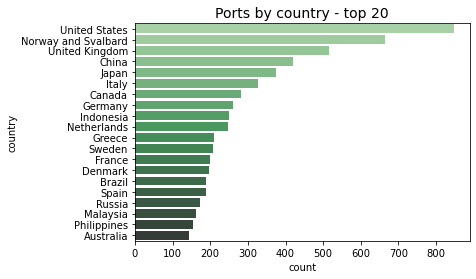

In [54]:
sns.countplot(y="country",  data=ports_df, palette="Greens_d",
              order=ports_df.country.value_counts().iloc[:20].index)
plt.title('Ports by country - top 20', fontsize=14)
plt.show()

## Vessels Info

In [32]:
vessels_df = pd.read_json('Data/vessels.json', orient='index')

In [33]:
print(vessels_df.shape)
print(vessels_df.info())
vessels_df.head()

(236478, 76)
<class 'pandas.core.frame.DataFrame'>
Index: 236478 entries, 0013b9cb66c349fce993732f to fff24803cf43df28552517ab
Data columns (total 76 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   _id                     236478 non-null  object 
 1   unifiedCount            155312 non-null  float64
 2   imo                     236270 non-null  float64
 3   created                 236478 non-null  object 
 4   class_calc              236357 non-null  object 
 5   fusion_sources          236474 non-null  object 
 6   generation_method       135358 non-null  object 
 7   has_only_properties     135358 non-null  float64
 8   imo_source              235850 non-null  object 
 9   is_read_only            135358 non-null  float64
 10  subclass_documented     234339 non-null  object 
 11  name                    230837 non-null  object 
 12  built_year              217180 non-null  float64
 13  deadweight              1

,_id,unifiedCount,imo,created,class_calc,fusion_sources,generation_method,has_only_properties,imo_source,is_read_only,...,splitIndex,vesselId,ww_fleets,ww_comments,lastMovementBlipId_B,lastpos_B,movementBlipCountTo_B,movementBlipCount_B,updatedLastMovement_B,isDeleted
0013b9cb66c349fce993732f,<not serializable>,1.0,9756896.0,<not serializable>,ServiceVessel,"{'class_calc': 'ihs', 'imo': 'ihs', 'subclass_...",external_sources,1.0,NTV,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001f4e31ee5c7cbd06917423,<not serializable>,1.0,9739616.0,<not serializable>,Passenger,"{'class_calc': 'ihs', 'imo': 'ihs', 'subclass_...",external_sources,1.0,NTV,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002d37106a4280749c3e66ed,<not serializable>,1.0,8797178.0,<not serializable>,Fishing,"{'class_calc': 'ihs', 'imo': 'ihs', 'subclass_...",external_sources,1.0,NTV,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0030ebd18e5e41406e5f98ca,<not serializable>,1.0,9778789.0,<not serializable>,ServiceVessel,"{'class_calc': 'ihs', 'imo': 'ihs', 'subclass_...",external_sources,1.0,NTV,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0032b4e89d483d7fcb48b2b3,<not serializable>,1.0,8537396.0,<not serializable>,Fishing,"{'class_calc': 'ihs', 'imo': 'ihs', 'subclass_...",external_sources,1.0,NTV,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
vessels_df['class_calc'].value_counts()

Cargo             87079
Fishing           45229
ServiceVessel     44056
Tanker            32386
Passenger         12535
Other              5899
MilitaryOrLaw      5376
Pleasure           3720
Unknown              46
HighSpeedCraft       31
Name: class_calc, dtype: int64

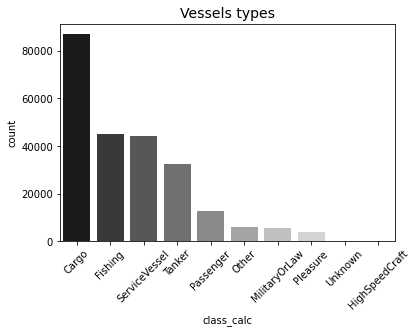

In [122]:
sns.countplot(x="class_calc",  data=vessels_df, palette="Greys_r",
             order=vessels_df.class_calc.value_counts().index)
plt.xticks(rotation=45)
plt.title('Vessels types', fontsize=14)
plt.show()

In [35]:
vessels_df['flag'].value_counts()

Panama          8855
China           5558
UnitedStates    5333
Indonesia       5329
Liberia         4706
                ... 
Afghanistan        1
Austria            1
PuertoRico         1
Macedonia          1
Rwanda             1
Name: flag, Length: 213, dtype: int64

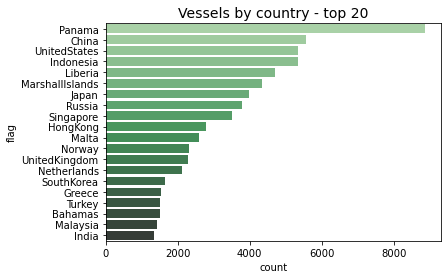

In [67]:
sns.countplot(y="flag",  data=vessels_df, palette="Greens_d",
              order=vessels_df.flag.value_counts().iloc[:20].index)
plt.title('Vessels by country - top 20', fontsize=14)
plt.show()

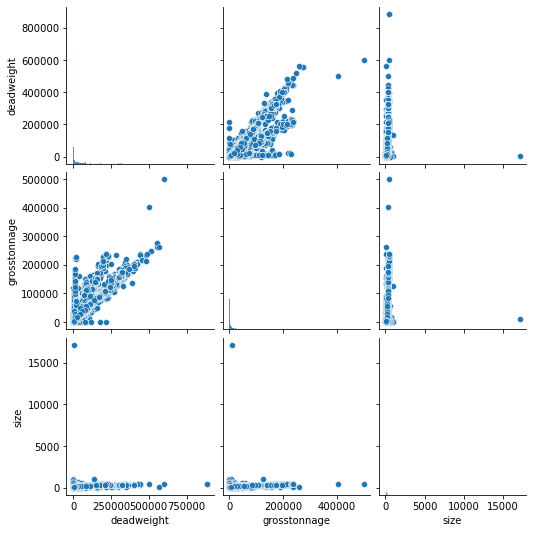

In [105]:
sns.pairplot(vessels_df.loc[:, ['deadweight','grosstonnage','size']])
plt.show()

In [104]:
vessels_df['size'].value_counts()

30.0     3363
26.0     3335
24.0     3177
29.0     2887
32.0     2789
         ... 
587.0       1
526.0       1
424.0       1
342.0       1
627.0       1
Name: size, Length: 417, dtype: int64

In [95]:
vessels_df['size'].median()

62.0

/Users/EF/opt/anaconda3/envs/geopandas_env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


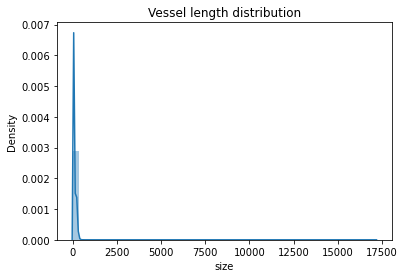

In [101]:
sns.distplot(vessels_df['size'])
plt.title('Vessel length distribution')
plt.show()

In [107]:
vessels_df['max_draught'].value_counts()

3.0 m           2013
3.2 m           1349
3.5 m           1328
4.0 m           1267
2.5 m           1110
                ... 
3.50999999 m       1
12.978 m           1
7.066 m            1
13.437 m           1
13.256 m           1
Name: max_draught, Length: 6077, dtype: int64

In [108]:
vessels_df['max_draught_num'] = vessels_df.max_draught.str.extract('(\d+)')

/Users/EF/opt/anaconda3/envs/geopandas_env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


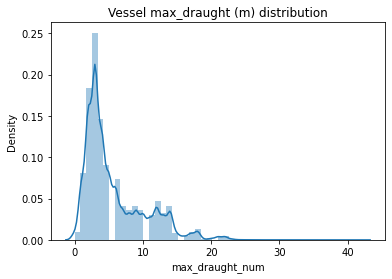

In [120]:
sns.distplot(vessels_df['max_draught_num'])
plt.title('Vessel max_draught (m) distribution')
plt.show()

## Polygons Info

In [124]:
polygons_df = pd.read_json('Data/polygons.json', orient='index')

In [125]:
print(polygons_df.shape)
print(polygons_df.info())
polygons_df.head()

(18133, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 18133 entries, 5358f8aab68ca120a07d4f3d to 5cff70a72c71dc66dcabe251
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _id         18133 non-null  object 
 1   type        18133 non-null  object 
 2   geometry    18133 non-null  object 
 3   properties  18133 non-null  object 
 4   __v         7682 non-null   float64
dtypes: float64(1), object(4)
memory usage: 850.0+ KB
None


,_id,type,geometry,properties,__v
5358f8aab68ca120a07d4f3d,<not serializable>,Feature,"{'type': 'Polygon', 'coordinates': [[[28.56363...","{'title': 'Vysotsk Coal, Ore Terminal', 'areaT...",NaN
5358f8aab68ca120a07d4f49,<not serializable>,Feature,"{'coordinates': [[[133.06989999999996, 42.7350...","{'createDate': '<not serializable>', 'updateDa...",NaN
5358f8aab68ca120a07d4f4a,<not serializable>,Feature,"{'coordinates': [[[133.06809999999996, 42.7361...","{'createDate': '<not serializable>', 'updateDa...",NaN
5358f8aab68ca120a07d4f62,<not serializable>,Feature,"{'type': 'Polygon', 'coordinates': [[[24.96983...","{'title': 'Helsinki, coal', 'areaType': 'Dock'...",NaN
5358f8aab68ca120a07d4f3b,<not serializable>,Feature,"{'coordinates': [[[149.31226156616208, -21.261...","{'isNew': True, 'createDate': '1970-01-01T00:0...",NaN


In [134]:
polygons_df.properties[768]

{'user': 'ariel.g.',
 'createDate': '<not serializable>',
 'verified': True,
 'pipeIds': '112',
 'updateDate': '<not serializable>',
 'title': '3 (803)',
 'operator': 'Port Authority. Direction des Operations et des Terminaux Petroliers de Fos (DOTPF)',
 'typesOfGoods': 'crude oil',
 'dockDWT': '',
 'dockLOA': '415',
 'dockBeam': '',
 'dockDraught': '21',
 'areaType': 'Dock',
 'numericId': 39658,
 'goods': [{'class': 'Dock',
   'commodity': {'dockType': 'WET',
    'goodType': 'CRUDE OIL',
    'country': '',
    'sulfur': 'NA',
    'api': 'NA',
    'name': 'CRUDE OIL'},
   'vesselCategory': ['vlcc'],
   'flow': 'import',
   'rateUnits': ''}],
 'isNew': True}

In [137]:
polygons_df['areaType'] = [d.get('areaType') for d in polygons_df.properties]


In [138]:
polygons_df['areaType'].value_counts()

Port               8352
Dock               5762
PortWaitingArea    4019
Name: areaType, dtype: int64

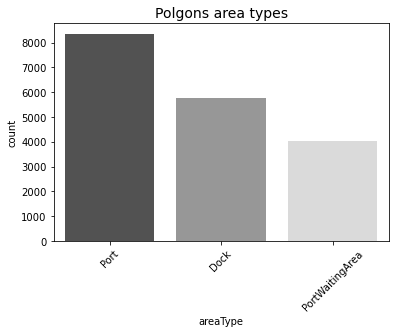

In [140]:
sns.countplot(x="areaType",  data=polygons_df, palette="Greys_r",
             order=polygons_df.areaType.value_counts().index)
plt.xticks(rotation=45)
plt.title('Polgons area types', fontsize=14)
plt.show()